In [1]:
import pandas as pd
pd.set_option("display.max_columns", 200)

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TunedThresholdClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, make_scorer, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn import set_config
set_config(transform_output="pandas")

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRFClassifier

from lightgbm import LGBMClassifier

import joblib

import sys
src_path = '../src'
sys.path.insert(0, src_path)
from eval_classification import eval_classification
del sys.path[0]

# Import preprocessor

In [2]:
saved = joblib.load("../lib/preprocessor.joblib")
preprocessor = saved["preprocessor"]

# Import data and merge other prepared data

In [3]:
input_path = "../../kaggle/input/home-credit-default-risk/" # on local machine
# input_path = "/kaggle/input/home-credit-default-risk/" # on Kaggle

application_train = pd.read_csv(input_path + "application_train.csv")
bureau_loans_and_balances = pd.read_csv("bureau_loans_and_balances.csv")
application_train = pd.merge(application_train, bureau_loans_and_balances, how="left", on="SK_ID_CURR")
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU,MONTHS_BALANCE,STATUS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,-109646.0,0.0,-40752.0,-72756.0,73472.58,0.0,12252772.26,3932496.0,127954.26,0.0,-69516.0,0.0,-2701.0,64.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,-5603.0,0.0,-2178.0,-3292.0,0.00,0.0,1017400.50,0

In [4]:
# split data
X = application_train.drop(columns=["TARGET", "SK_ID_CURR"])
y = application_train["TARGET"].copy()

In [5]:
# Training split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
preprocessor.fit(X_train, y_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

# Model Testing

## Logistic Regression

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    226132             0       0.96      0.68      0.80     56554 
           1       0.16      0.67      0.26     19876             1       0.16      0.67      0.25      4949 
                                                                                                             
    accuracy                           0.68    246008      accuracy                           0.68     61503 
   macro avg       0.56      0.68      0.53    246008     macro avg       0.56      0.68      0.53     61503 
weighted avg       0.89      0.68      0.76    246008  weighted avg       0.89      0.68      0.75     61503 


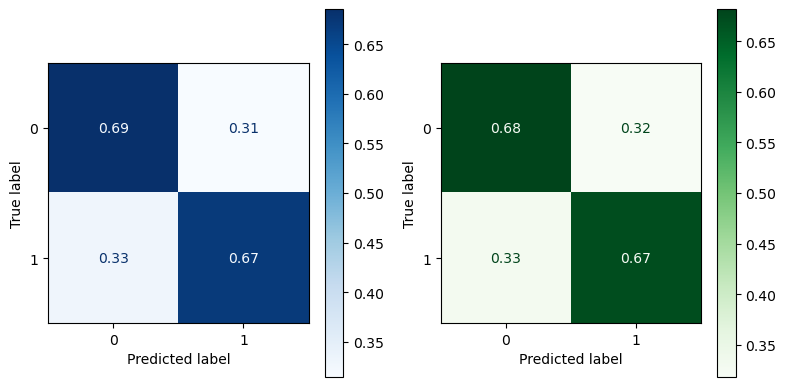

In [7]:
logreg = LogisticRegression(max_iter=1000, class_weight="balanced").fit(X_train, y_train)
  
logreg_results = eval_classification(logreg, X_train, y_train, X_test, y_test,
                              model_name="Logistic Regression")

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    226132             0       0.96      0.68      0.80     56554 
           1       0.16      0.67      0.26     19876             1       0.16      0.67      0.25      4949 
                                                                                                             
    accuracy                           0.68    246008      accuracy                           0.68     61503 
   macro avg       0.56      0.68      0.53    246008     macro avg       0.56      0.68      0.53     61503 
weighted avg       0.89      0.68      0.76    246008  weighted avg       0.89      0.68      0.75     61503 


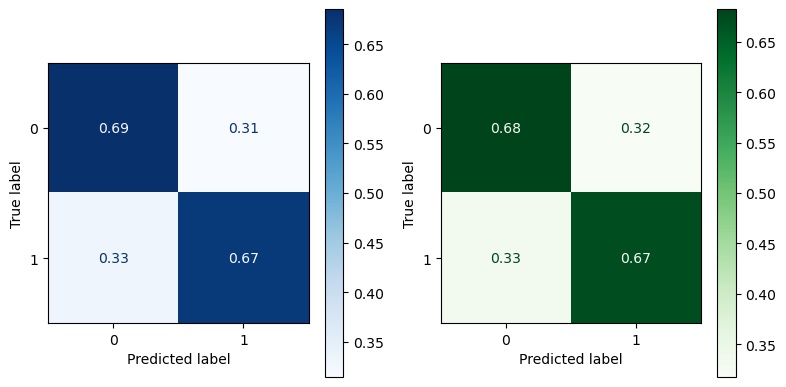

In [8]:
logreg_cv = LogisticRegressionCV(max_iter=1000, class_weight="balanced", Cs=100, cv=8, scoring="roc_auc").fit(X_train, y_train)

logreg_cv_results = eval_classification(logreg_cv, X_train, y_train, X_test, y_test,
                              model_name="Logistic Regression CV", results_frame=logreg_results)

## Decision Trees

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    226132             0       0.93      0.92      0.92     56554 
           1       1.00      1.00      1.00     19876             1       0.15      0.16      0.15      4949 
                                                                                                             
    accuracy                           1.00    246008      accuracy                           0.86     61503 
   macro avg       1.00      1.00      1.00    246008     macro avg       0.54      0.54      0.54     61503 
weighted avg       1.00      1.00      1.00    246008  weighted avg       0.86      0.86      0.86     61503 


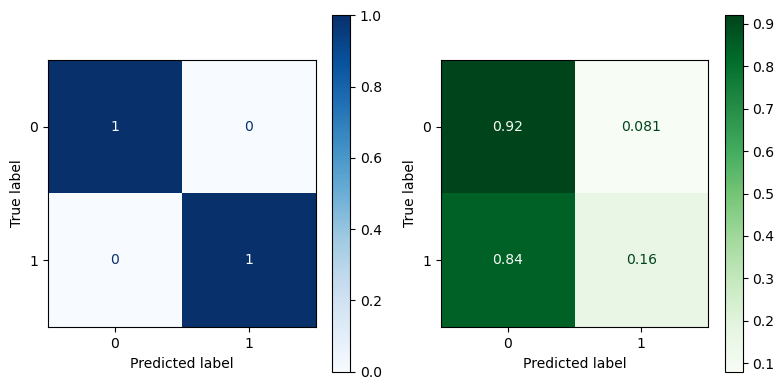

In [9]:
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced").fit(X_train, y_train)

dt_results = eval_classification(dt, X_train, y_train, X_test, y_test, 
                                  model_name="Decision Tree", results_frame=logreg_cv_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.95      0.71      0.81    226132             0       0.95      0.70      0.81     56554 
           1       0.15      0.61      0.25     19876             1       0.15      0.60      0.24      4949 
                                                                                                             
    accuracy                           0.70    246008      accuracy                           0.70     61503 
   macro avg       0.55      0.66      0.53    246008     macro avg       0.55      0.65      0.53     61503 
weighted avg       0.89      0.70      0.77    246008  weighted avg       0.89      0.70      0.76     61503 


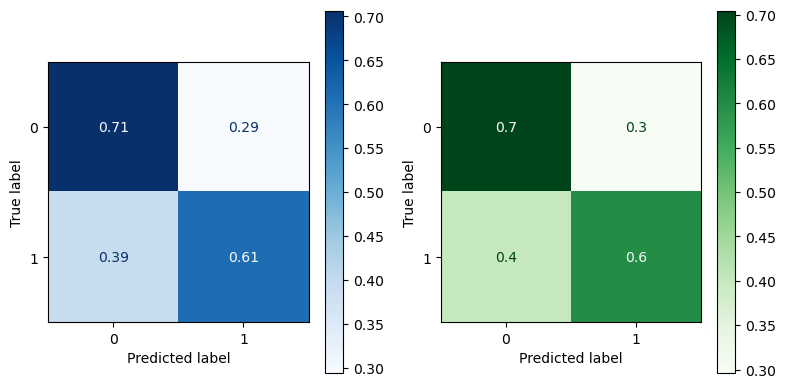

In [10]:
dt_params = {'max_depth': range(1, dt.get_depth() + 1, 4)}
dt_gs = GridSearchCV(dt, dt_params, scoring="roc_auc")
dt_gs.fit(X_train, y_train)
dt_cv = dt_gs.best_estimator_.fit(X_train, y_train)

dt_cv_results = eval_classification(dt_cv, X_train, y_train, X_test, y_test, 
                                  model_name="Decision Tree CV", results_frame=dt_results)

## K Nearest Neighbors

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.93      1.00      0.96    226132             0       0.92      0.99      0.95     56554 
           1       0.67      0.09      0.16     19876             1       0.21      0.03      0.05      4949 
                                                                                                             
    accuracy                           0.92    246008      accuracy                           0.91     61503 
   macro avg       0.80      0.54      0.56    246008     macro avg       0.56      0.51      0.50     61503 
weighted avg       0.91      0.92      0.90    246008  weighted avg       0.86      0.91      0.88     61503 


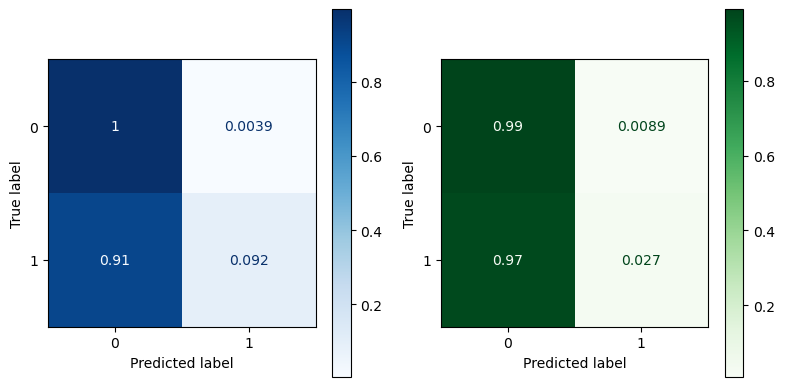

In [11]:
knn = KNeighborsClassifier().fit(X_train, y_train)

knn_results = eval_classification(knn, X_train, y_train, X_test, y_test, 
                                  model_name="K Nearest Neighbors", results_frame=dt_cv_results)

In [12]:
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.92      1.00      0.96    226132             0       0.92      1.00      0.96     56554 
           1       0.65      0.04      0.08     19876             1       0.24      0.02      0.03      4949 
                                                                                                             
    accuracy                           0.92    246008      accuracy                           0.92     61503 
   macro avg       0.79      0.52      0.52    246008     macro avg       0.58      0.51      0.49     61503 
weighted avg       0.90      0.92      0.89    246008  weighted avg       0.87      0.92      0.88     61503 


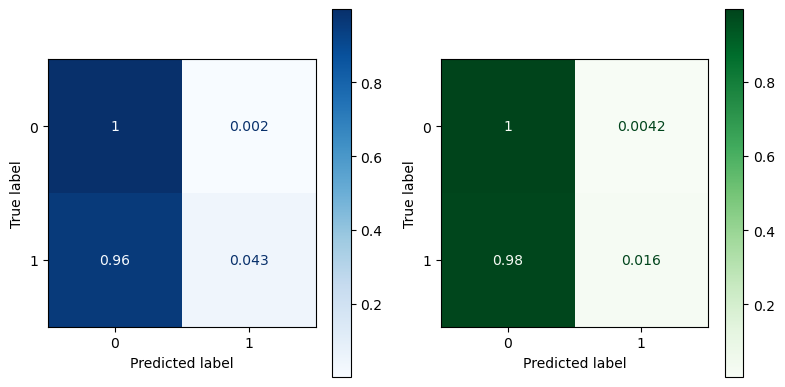

In [13]:
knn_params = {'n_neighbors': range(3,8),
              'leaf_size': [10, 20, 30, 40, 50]}
knn_gs = GridSearchCV(knn, knn_params, scoring="roc_auc")
knn_gs.fit(X_train, y_train)
knn_cv = knn_gs.best_estimator_.fit(X_train, y_train)

knn_cv_results = eval_classification(knn_cv, X_train, y_train, X_test, y_test, 
                                  model_name="K Nearest Neighbors CV", results_frame=knn_results)

## Random Forests

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    226132             0       0.92      1.00      0.96     56554 
           1       1.00      1.00      1.00     19876             1       0.40      0.00      0.00      4949 
                                                                                                             
    accuracy                           1.00    246008      accuracy                           0.92     61503 
   macro avg       1.00      1.00      1.00    246008     macro avg       0.66      0.50      0.48     61503 
weighted avg       1.00      1.00      1.00    246008  weighted avg       0.88      0.92      0.88     61503 


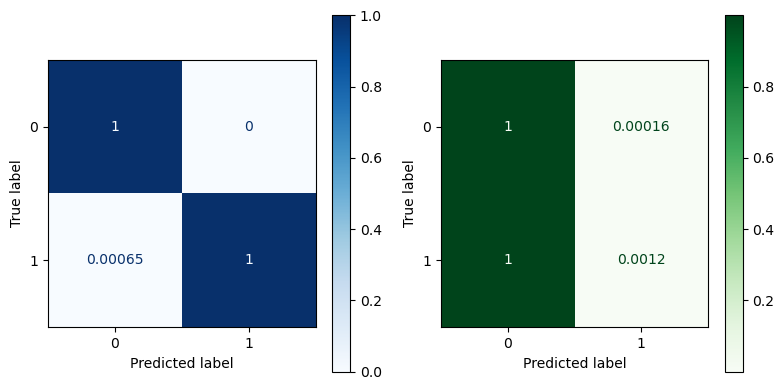

In [14]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

rf_results = eval_classification(rf, X_train, y_train, X_test, y_test, 
                                  model_name="Random Forest", results_frame=knn_cv_results)

In [15]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [16]:
rf_params = {"class_weight" : ["balanced", "balanced_subsample"],
             "n_estimators" : [10, 50, 100, 150]}
rf_gs = GridSearchCV(rf, rf_params, scoring="roc_auc")
rf_gs.fit(X_train, y_train)
rf_cv = rf_gs.best_estimator_.fit(X_train, y_train)

rf_cv_results = eval_classification(rf_cv, X_train, y_train, X_test, y_test, 
                                  model_name="Random Forest CV", results_frame=rf_results)

KeyboardInterrupt: 

## Ridge regression classifier

In [ ]:
ridge = RidgeClassifier(random_state=42, class_weight="balanced")
ridge.fit(X_train, y_train)

ridge_results = eval_classification(ridge, X_train, y_train, X_test, y_test,
                              model_name="Ridge Classifier", results_frame=rf_cv_results)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE', 'FLAG_MO...
                                                   'AMT_CREDIT_MAX_OVERDUE',
                                                   'CNT_CREDIT_PROLONG',
                                                   'AMT_CREDIT_SUM',
                                                   'AMT_CREDIT_SUM_DEBT',
                                                   'AMT_CREDIT_SUM_LIMIT',
                                                   'AMT_CREDIT_SUM_OVERDUE',
                                                   'DAYS_CREDIT_UPDATE',
                                                   'AMT_ANNUITY_BUREAU',
                                                   'MONTHS_BALANCE',
                                                   'STATUS'])],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler()),
                ('ridgeclassifier',
                 RidgeClassifier(class_weight='balanced', random_state=42))])

In [ ]:
ridge_cv = RidgeClassifierCV(class_weight="balanced", scoring="roc_auc")
ridge.fit(X_train, y_train)

ridge_cv_results = eval_classification(ridge_cv_pipe, X_train, y_train, X_test, y_test,
                              model_name="Ridge Classifier CV", results_frame=rf_cv_results, roc_auc_average="macro")

ridge_cv_results

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'OWN_CAR_AGE', 'FLAG_MO...
                                                   'AMT_CREDIT_MAX_OVERDUE',
                                                   'CNT_CREDIT_PROLONG',
                                                   'AMT_CREDIT_SUM',
                                                   'AMT_CREDIT_SUM_DEBT',
                                                   'AMT_CREDIT_SUM_LIMIT',
                                                   'AMT_CREDIT_SUM_OVERDUE',
                                                   'DAYS_CREDIT_UPDATE',
                                                   'AMT_ANNUITY_BUREAU',
                                                   'MONTHS_BALANCE',
                                                   'STATUS'])],
                                   verbose_feature_names_out=False)),
                ('standardscaler', StandardScaler()),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(class_weight='balanced',
                                   scoring='roc_auc'))])

In [29]:
roc_auc_score(y_train, ridge_cv_pipe.predict(X_train))

0.6793533925793831

In [30]:
roc_auc_score(y_test, ridge_cv_pipe.predict(X_test))

0.6718807692892294

Train Evaluation
              precision    recall  f1-score   support

           0       0.97      0.73      0.84     56549
           1       0.20      0.77      0.32      4953

    accuracy                           0.74     61502
   macro avg       0.59      0.75      0.58     61502
weighted avg       0.91      0.74      0.79     61502



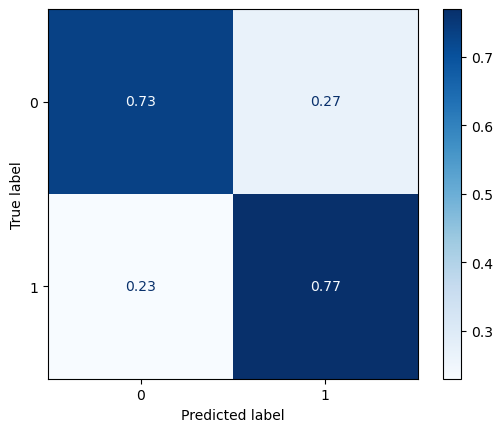

Test Evaluation
              precision    recall  f1-score   support

           0       0.96      0.72      0.82    226137
           1       0.17      0.64      0.27     19872

    accuracy                           0.72    246009
   macro avg       0.56      0.68      0.55    246009
weighted avg       0.89      0.72      0.78    246009



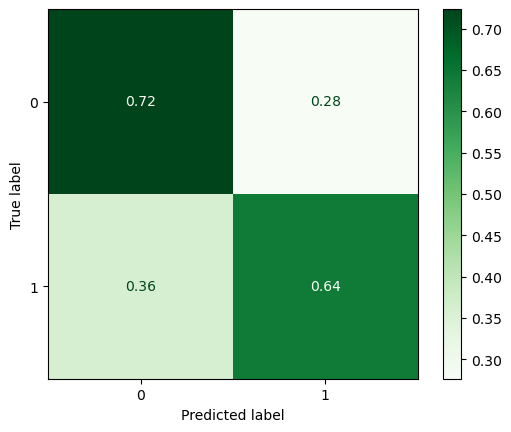

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.685262,0.683199,0.158187,0.155390,0.672925,0.658766,0.256158,0.251465,0.745679,0.731948
Logistic Regression CV,0.685018,0.682934,0.157945,0.155336,0.672118,0.659169,0.255782,0.251423,0.745881,0.732218
Decision Tree,1.000000,0.855997,1.000000,0.142929,1.000000,0.156653,1.000000,0.149477,1.000000,0.537053
Decision Tree CV,0.651735,0.648358,0.142510,0.138258,0.662629,0.640801,0.234571,0.227444,0.709635,0.690478
K Nearest Neighbors,0.922523,0.913910,0.685771,0.161574,0.070059,0.015700,0.127130,0.028620,0.897560,0.560490
K Nearest Neighbors CV,0.920620,0.917357,0.665116,0.203105,0.028871,0.007901,0.055341,0.015209,0.868297,0.572359
Random Forest,0.999967,0.919243,1.000000,0.666667,0.999596,0.000503,0.999798,0.001006,1.000000,0.704284
Random Forest CV,1.000000,0.919186,1.000000,0.378378,1.000000,0.000705,1.000000,0.001406,1.000000,0.723484
Histogram-based Gradient Boosting Classification Tree,0.736366,0.716913,0.201916,0.169082,0.770038,0.639845,0.319940,0.267481,0.833163,0.746252


In [31]:
hgb = HistGradientBoostingClassifier(scoring="roc_auc", random_state=42, class_weight="balanced")
hgb_pipe = make_pipeline(preprocessor, StandardScaler(), hgb).fit(X_train, y_train)

hgb_results = eval_classification(hgb_pipe, X_train, y_train, X_test, y_test, 
                                  model_name="Histogram-based Gradient Boosting Classification Tree", results_frame=rf_cv_results)

hgb_results

Train Evaluation
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     56549
           1       0.97      0.28      0.43      4953

    accuracy                           0.94     61502
   macro avg       0.95      0.64      0.70     61502
weighted avg       0.94      0.94      0.93     61502



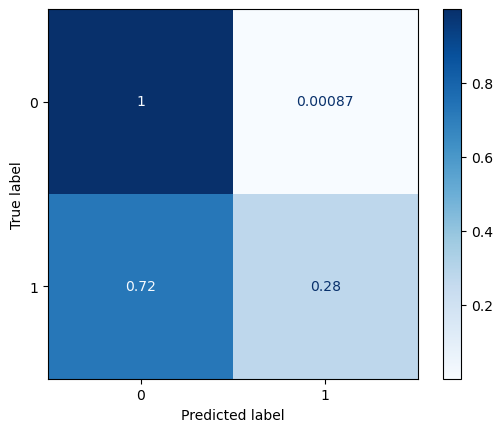

Test Evaluation
              precision    recall  f1-score   support

           0       0.92      0.99      0.96    226137
           1       0.39      0.04      0.08     19872

    accuracy                           0.92    246009
   macro avg       0.66      0.52      0.52    246009
weighted avg       0.88      0.92      0.89    246009



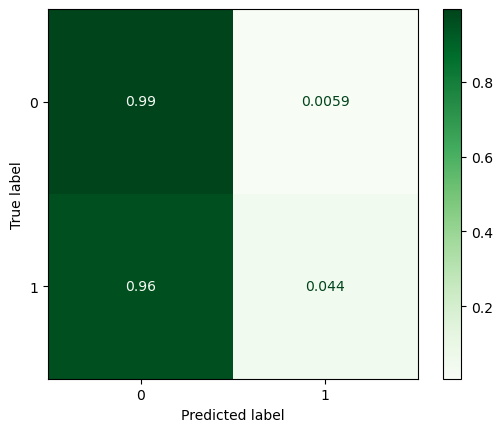

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.685262,0.683199,0.158187,0.155390,0.672925,0.658766,0.256158,0.251465,0.745679,0.731948
Logistic Regression CV,0.685018,0.682934,0.157945,0.155336,0.672118,0.659169,0.255782,0.251423,0.745881,0.732218
Decision Tree,1.000000,0.855997,1.000000,0.142929,1.000000,0.156653,1.000000,0.149477,1.000000,0.537053
Decision Tree CV,0.651735,0.648358,0.142510,0.138258,0.662629,0.640801,0.234571,0.227444,0.709635,0.690478
K Nearest Neighbors,0.922523,0.913910,0.685771,0.161574,0.070059,0.015700,0.127130,0.028620,0.897560,0.560490
K Nearest Neighbors CV,0.920620,0.917357,0.665116,0.203105,0.028871,0.007901,0.055341,0.015209,0.868297,0.572359
Random Forest,0.999967,0.919243,1.000000,0.666667,0.999596,0.000503,0.999798,0.001006,1.000000,0.704284
Random Forest CV,1.000000,0.919186,1.000000,0.378378,1.000000,0.000705,1.000000,0.001406,1.000000,0.723484
Histogram-based Gradient Boosting Classification Tree,0.736366,0.716913,0.201916,0.169082,0.770038,0.639845,0.319940,0.267481,0.833163,0.746252
XGBoost,0.941010,0.917312,0.965566,0.393472,0.277408,0.043680,0.430991,0.078630,0.955115,0.725264


In [32]:
xgb = XGBClassifier()
xgb_pipe = make_pipeline(preprocessor, StandardScaler(), xgb).fit(X_train, y_train)

xgb_results = eval_classification(xgb_pipe, X_train, y_train, X_test, y_test, 
                                  model_name="XGBoost", results_frame=hgb_results)

xgb_results

Train Evaluation
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     56549
           1       0.43      0.14      0.21      4953

    accuracy                           0.92     61502
   macro avg       0.68      0.56      0.58     61502
weighted avg       0.89      0.92      0.90     61502



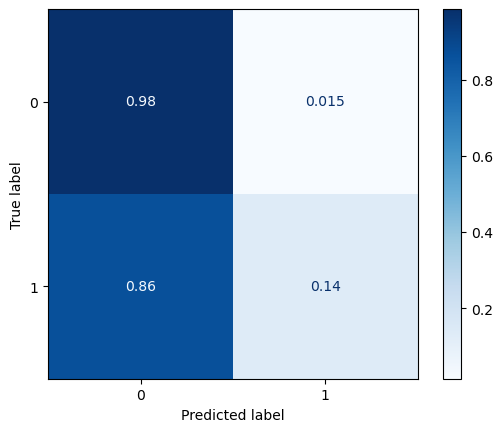

Test Evaluation
              precision    recall  f1-score   support

           0       0.93      0.98      0.95    226137
           1       0.33      0.10      0.15     19872

    accuracy                           0.91    246009
   macro avg       0.63      0.54      0.55    246009
weighted avg       0.88      0.91      0.89    246009



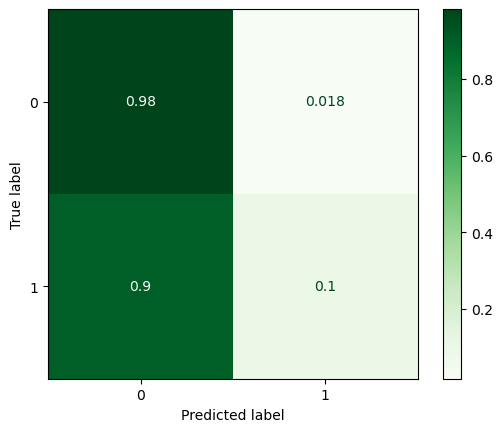

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.685262,0.683199,0.158187,0.155390,0.672925,0.658766,0.256158,0.251465,0.745679,0.731948
Logistic Regression CV,0.685018,0.682934,0.157945,0.155336,0.672118,0.659169,0.255782,0.251423,0.745881,0.732218
Decision Tree,1.000000,0.855997,1.000000,0.142929,1.000000,0.156653,1.000000,0.149477,1.000000,0.537053
Decision Tree CV,0.651735,0.648358,0.142510,0.138258,0.662629,0.640801,0.234571,0.227444,0.709635,0.690478
K Nearest Neighbors,0.922523,0.913910,0.685771,0.161574,0.070059,0.015700,0.127130,0.028620,0.897560,0.560490
K Nearest Neighbors CV,0.920620,0.917357,0.665116,0.203105,0.028871,0.007901,0.055341,0.015209,0.868297,0.572359
Random Forest,0.999967,0.919243,1.000000,0.666667,0.999596,0.000503,0.999798,0.001006,1.000000,0.704284
Random Forest CV,1.000000,0.919186,1.000000,0.378378,1.000000,0.000705,1.000000,0.001406,1.000000,0.723484
Histogram-based Gradient Boosting Classification Tree,0.736366,0.716913,0.201916,0.169082,0.770038,0.639845,0.319940,0.267481,0.833163,0.746252
XGBoost,0.941010,0.917312,0.965566,0.393472,0.277408,0.043680,0.430991,0.078630,0.955115,0.725264


In [33]:
xgbrf = XGBRFClassifier()
xgbrf_pipe = make_pipeline(preprocessor, StandardScaler(), xgbrf).fit(X_train, y_train)

xgbrf_results = eval_classification(xgbrf_pipe, X_train, y_train, X_test, y_test, 
                                  model_name="XGBoost Random Forest", results_frame=xgb_results)

xgbrf_results

In [42]:
xgbrf_results.sort_values(by="test_auc")

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Decision Tree,1.000000,0.855997,1.000000,0.142929,1.000000,0.156653,1.000000,0.149477,1.000000,0.537053
K Nearest Neighbors,0.922523,0.913910,0.685771,0.161574,0.070059,0.015700,0.127130,0.028620,0.897560,0.560490
K Nearest Neighbors CV,0.920620,0.917357,0.665116,0.203105,0.028871,0.007901,0.055341,0.015209,0.868297,0.572359
Decision Tree CV,0.651735,0.648358,0.142510,0.138258,0.662629,0.640801,0.234571,0.227444,0.709635,0.690478
Random Forest,0.999967,0.919243,1.000000,0.666667,0.999596,0.000503,0.999798,0.001006,1.000000,0.704284
XGBoost Random Forest,0.916182,0.910662,0.434670,0.327660,0.135675,0.100745,0.206801,0.154107,0.747202,0.722195
Random Forest CV,1.000000,0.919186,1.000000,0.378378,1.000000,0.000705,1.000000,0.001406,1.000000,0.723484
XGBoost,0.941010,0.917312,0.965566,0.393472,0.277408,0.043680,0.430991,0.078630,0.955115,0.725264
Logistic Regression,0.685262,0.683199,0.158187,0.155390,0.672925,0.658766,0.256158,0.251465,0.745679,0.731948
Logistic Regression CV,0.685018,0.682934,0.157945,0.155336,0.672118,0.659169,0.255782,0.251423,0.745881,0.732218


Train Evaluation
              precision    recall  f1-score   support

           0       0.95      0.04      0.07     56549
           1       0.08      0.98      0.15      4953

    accuracy                           0.11     61502
   macro avg       0.52      0.51      0.11     61502
weighted avg       0.88      0.11      0.08     61502



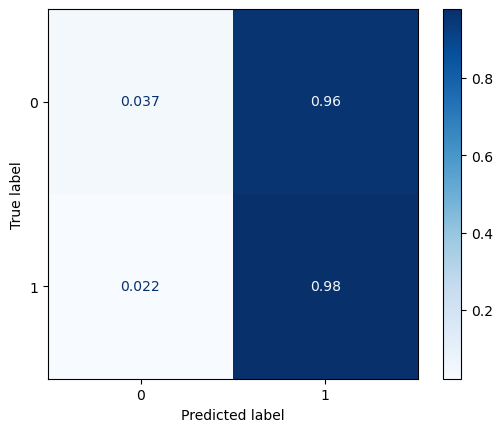

Test Evaluation
              precision    recall  f1-score   support

           0       0.95      0.04      0.07    226137
           1       0.08      0.98      0.15     19872

    accuracy                           0.11    246009
   macro avg       0.52      0.51      0.11    246009
weighted avg       0.88      0.11      0.08    246009



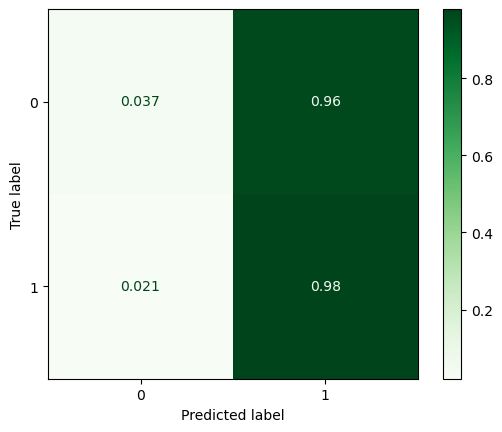

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.685262,0.683199,0.158187,0.155390,0.672925,0.658766,0.256158,0.251465,0.745679,0.731948
Logistic Regression CV,0.685018,0.682934,0.157945,0.155336,0.672118,0.659169,0.255782,0.251423,0.745881,0.732218
Decision Tree,1.000000,0.855997,1.000000,0.142929,1.000000,0.156653,1.000000,0.149477,1.000000,0.537053
Decision Tree CV,0.651735,0.648358,0.142510,0.138258,0.662629,0.640801,0.234571,0.227444,0.709635,0.690478
K Nearest Neighbors,0.922523,0.913910,0.685771,0.161574,0.070059,0.015700,0.127130,0.028620,0.897560,0.560490
K Nearest Neighbors CV,0.920620,0.917357,0.665116,0.203105,0.028871,0.007901,0.055341,0.015209,0.868297,0.572359
Random Forest,0.999967,0.919243,1.000000,0.666667,0.999596,0.000503,0.999798,0.001006,1.000000,0.704284
Random Forest CV,1.000000,0.919186,1.000000,0.378378,1.000000,0.000705,1.000000,0.001406,1.000000,0.723484
Histogram-based Gradient Boosting Classification Tree,0.736366,0.716913,0.201916,0.169082,0.770038,0.639845,0.319940,0.267481,0.833163,0.746252
XGBoost,0.941010,0.917312,0.965566,0.393472,0.277408,0.043680,0.430991,0.078630,0.955115,0.725264


In [ ]:
from sklearn.naive_bayes import GaussianNB

base_clf = GaussianNB()
base_clf_pipe = make_pipeline(preprocessor, StandardScaler(), base_clf).fit(X_train, y_train)

base_clf_results = eval_classification(base_clf_pipe, X_train, y_train, X_test, y_test, 
                                  model_name="Gaussian", results_frame=stacked_results)

base_clf_results

Train Evaluation
              precision    recall  f1-score   support

           0       0.93      0.89      0.91     56549
           1       0.18      0.27      0.22      4953

    accuracy                           0.84     61502
   macro avg       0.56      0.58      0.57     61502
weighted avg       0.87      0.84      0.86     61502



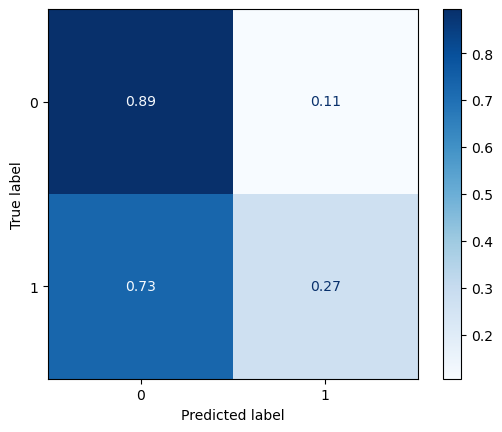

Test Evaluation
              precision    recall  f1-score   support

           0       0.93      0.90      0.91    226137
           1       0.19      0.28      0.23     19872

    accuracy                           0.85    246009
   macro avg       0.56      0.59      0.57    246009
weighted avg       0.87      0.85      0.86    246009



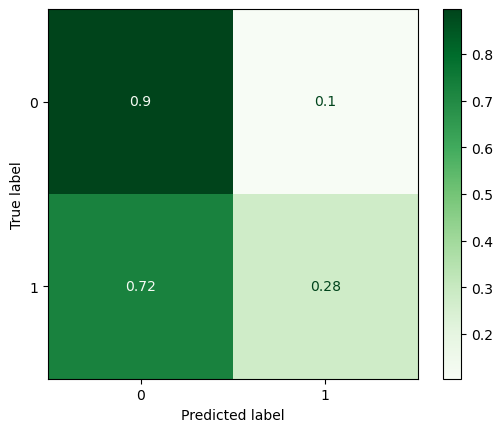

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.685262,0.683199,0.158187,0.155390,0.672925,0.658766,0.256158,0.251465,0.745679,0.731948
Logistic Regression CV,0.685018,0.682934,0.157945,0.155336,0.672118,0.659169,0.255782,0.251423,0.745881,0.732218
Decision Tree,1.000000,0.855997,1.000000,0.142929,1.000000,0.156653,1.000000,0.149477,1.000000,0.537053
Decision Tree CV,0.651735,0.648358,0.142510,0.138258,0.662629,0.640801,0.234571,0.227444,0.709635,0.690478
K Nearest Neighbors,0.922523,0.913910,0.685771,0.161574,0.070059,0.015700,0.127130,0.028620,0.897560,0.560490
K Nearest Neighbors CV,0.920620,0.917357,0.665116,0.203105,0.028871,0.007901,0.055341,0.015209,0.868297,0.572359
Random Forest,0.999967,0.919243,1.000000,0.666667,0.999596,0.000503,0.999798,0.001006,1.000000,0.704284
Random Forest CV,1.000000,0.919186,1.000000,0.378378,1.000000,0.000705,1.000000,0.001406,1.000000,0.723484
Histogram-based Gradient Boosting Classification Tree,0.736366,0.716913,0.201916,0.169082,0.770038,0.639845,0.319940,0.267481,0.833163,0.746252
XGBoost,0.941010,0.917312,0.965566,0.393472,0.277408,0.043680,0.430991,0.078630,0.955115,0.725264


In [ ]:
from sklearn.naive_bayes import BernoulliNB

ber_clf = BernoulliNB()
ber_clf_pipe = make_pipeline(preprocessor, StandardScaler(), ber_clf).fit(X_train, y_train)

ber_clf_results = eval_classification(ber_clf_pipe, X_train, y_train, X_test, y_test, 
                                  model_name="Bernoulli", results_frame=base_clf_results)

ber_clf_results

In [ ]:
dt_cv_results.style.background_gradient()

# Stacking Classifier

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Train Evaluation
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     56549
           1       1.00      0.30      0.46      4953

    accuracy                           0.94     61502
   macro avg       0.97      0.65      0.71     61502
weighted avg       0.95      0.94      0.93     61502



/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


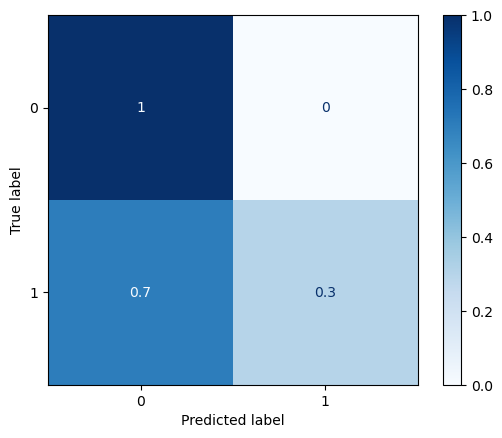

Test Evaluation
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226137
           1       0.55      0.01      0.03     19872

    accuracy                           0.92    246009
   macro avg       0.74      0.51      0.49    246009
weighted avg       0.89      0.92      0.88    246009



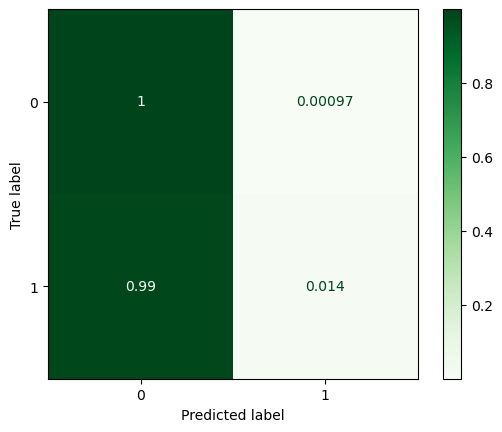

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [70]:
estimators = [('rf', rf_cv_pipe),
              ('svc', make_pipeline(preprocessor, StandardScaler(), LinearSVC(random_state=42))),
              ('hgb', hgb_pipe),
              ('xgb', xgb_pipe),
              ('dt', dt_cv_pipe),
              ('clf', logreg_cv_pipe)]

clf_stack = StackingClassifier(estimators=estimators).fit(X_train, y_train)

stacked_results = eval_classification(clf_stack, X_train, y_train, X_test, y_test, 
                                  model_name="Stacked Classifier", results_frame=xgbrf_results)


In [59]:
stacked_results

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.685262,0.683199,0.158187,0.155390,0.672925,0.658766,0.256158,0.251465,0.745679,0.731948
Logistic Regression CV,0.685018,0.682934,0.157945,0.155336,0.672118,0.659169,0.255782,0.251423,0.745881,0.732218
Decision Tree,1.000000,0.855997,1.000000,0.142929,1.000000,0.156653,1.000000,0.149477,1.000000,0.537053
Decision Tree CV,0.651735,0.648358,0.142510,0.138258,0.662629,0.640801,0.234571,0.227444,0.709635,0.690478
K Nearest Neighbors,0.922523,0.913910,0.685771,0.161574,0.070059,0.015700,0.127130,0.028620,0.897560,0.560490
K Nearest Neighbors CV,0.920620,0.917357,0.665116,0.203105,0.028871,0.007901,0.055341,0.015209,0.868297,0.572359
Random Forest,0.999967,0.919243,1.000000,0.666667,0.999596,0.000503,0.999798,0.001006,1.000000,0.704284
Random Forest CV,1.000000,0.919186,1.000000,0.378378,1.000000,0.000705,1.000000,0.001406,1.000000,0.723484
Histogram-based Gradient Boosting Classification Tree,0.736366,0.716913,0.201916,0.169082,0.770038,0.639845,0.319940,0.267481,0.833163,0.746252
XGBoost,0.941010,0.917312,0.965566,0.393472,0.277408,0.043680,0.430991,0.078630,0.955115,0.725264


# Threshold Tuning

In [ ]:
# tuned_threshold = TunedThresholdClassifierCV(clf_stack, random_state=42).fit(X_train, y_train)

# tuned_threshold_results = eval_classification(tuned_threshold, X_train, y_train, X_test, y_test, 
#                                   model_name="Tuned Threshold Classifer", results_frame=stacked_results)

# tuned_threshold_results

# Calibration

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV


base_clf.fit(X_train, y_train)
from sklearn.frozen import FrozenEstimator
calibrated_clf = CalibratedClassifierCV(FrozenEstimator(base_clf))
calibrated_clf.fit(X_calib, y_calib)
len(calibrated_clf.calibrated_classifiers_)
calibrated_clf.predict_proba([[-0.5, 0.5]])

In [ ]:
from sklearn.naive_bayes import BernoulliNB

ber_clf = BernoulliNB()
ber_clf_pipe = make_pipeline(preprocessor, StandardScaler(), ber_clf).fit(X_train, y_train)

ber_clf_results = eval_classification(ber_clf_pipe, X_train, y_train, X_test, y_test, 
                                  model_name="Bernoulli", results_frame=base_clf_results)

ber_clf_results

# Export and Submission

In [ ]:
test_data_file = "application_test.csv"
application_test = pd.read_csv(input_path + test_data_file)

application_test = pd.merge(application_test, bureau_loans_and_balances, how="left", on="SK_ID_CURR")

ids = application_test.pop("SK_ID_CURR")
preds = clf_stack.predict_proba(application_test)[:,1]

output = pd.DataFrame({"SK_ID_CURR": ids,
                       "TARGET": preds})

/opt/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [45]:
output

,SK_ID_CURR,TARGET
0,100001,0.042513
1,100005,0.165628
2,100013,0.024599
3,100028,0.043649
4,100038,0.158436
...,...,...
48739,456221,0.039934
48740,456222,0.079393
48741,456223,0.046804
48742,456224,0.035044


In [ ]:
# sample_submission_file = "sample_submission.csv"
# sample_submission_df = pd.read_csv(input_path + sample_submission_file)
# sample_submission_df["TARGET"] = preds
# sample_submission_df.to_csv("02_new_stack.csv", index=False)
# sample_submission_df.head()

,SK_ID_CURR,TARGET
0,100001,0.042513
1,100005,0.165628
2,100013,0.024599
3,100028,0.043649
4,100038,0.158436
